In [1]:
from ast import literal_eval
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import ticker
from sklearn.cluster import KMeans
from shapely.geometry import box, Point
import contextily as cx

import sys
sys.path.append('..')
from db_utils import get_rect_to_rect_data, DatabaseConnection

In [2]:
# use this style for better visibility in histograms
plt.style.use('seaborn-white')
plt_kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, ec="k")

# latex style plot font
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)

/tmp/ipykernel_76741/3630067782.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [3]:
# sumo_sim_file = "./sim_data/prinzenstr_new_params.csv"
# sumo_sim_file = "./sim_data/oranienstr_new_params.csv"
sumo_sim_file = "../../parameterization_eval/sim_data/prinzenstr_new_params.csv"

In [4]:
# Oranienstr
# start_rect_coords = (13.426,52.4991, 13.4264,52.4998)
# end_rect_coords = (13.4112,52.5031, 13.4117,52.5039)

# Prinzenstr
start_rect_coords = (13.4154,52.5102,13.4168,52.5108)
end_rect_coords = (13.4062,52.4987,13.4081,52.4994)

In [5]:
df_simra = get_rect_to_rect_data(start_rect_coords, end_rect_coords)
df_simra_paths = df_simra[['filename', 'ts', 'lon', 'lat', 'velo']]
df_simra_paths.rename({'filename': 'ride_id'}, axis='columns', inplace=True)

Number of rows: 30096
Number of rides: 468


/tmp/ipykernel_76741/225101545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simra_paths.rename({'filename': 'ride_id'}, axis='columns', inplace=True)


In [6]:
df_sumo = pd.read_csv(sumo_sim_file, delimiter=';')
df_sumo_paths = df_sumo[['vehicle_id', 'timestep_time', 'vehicle_x', 'vehicle_y', 'vehicle_speed']]
df_sumo_paths.rename({'vehicle_id': 'ride_id', 'timestep_time': 'ts', 'vehicle_x': 'lon', 'vehicle_y': 'lat', 'vehicle_speed': 'velo'}, axis='columns', inplace=True)

/tmp/ipykernel_76741/1389641402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sumo_paths.rename({'vehicle_id': 'ride_id', 'timestep_time': 'ts', 'vehicle_x': 'lon', 'vehicle_y': 'lat', 'vehicle_speed': 'velo'}, axis='columns', inplace=True)


In [7]:
n_rides = {'SUMO': len(df_sumo_paths.groupby('ride_id')), 'SimRa': len(df_simra_paths.groupby('ride_id'))}

print(f"Number of rides: {n_rides['SUMO']}")

Number of rides: 98


In [8]:
start_rect = box(*start_rect_coords)
end_rect = box(*end_rect_coords)

def get_indices_to_delete(ride_group):
    
    mask_first = ride_group.apply(lambda coord: start_rect.contains(Point(coord['lon'], coord['lat'])), axis=1)
    mask_end = ride_group.apply(lambda coord: end_rect.contains(Point(coord['lon'], coord['lat'])), axis=1)    
    try:
        start_idx = mask_first[mask_first==True].index[0]
        end_idx = mask_end[mask_end==True].index[-1]
        return [idx for idx in ride_group.index if idx < start_idx or idx > end_idx]
    except: 
        # probably vehicle (ride) does not arrive in end box because simulation ended beforehand
        return list(ride_group.index)

grouped = df_sumo_paths.groupby('ride_id')
for _, ride_group in grouped:
    indices_to_delete = get_indices_to_delete(ride_group)
    df_sumo_paths.drop(index=get_indices_to_delete(ride_group), inplace=True)

/tmp/ipykernel_76741/787810660.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sumo_paths.drop(index=get_indices_to_delete(ride_group), inplace=True)
/tmp/ipykernel_76741/787810660.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sumo_paths.drop(index=get_indices_to_delete(ride_group), inplace=True)
/tmp/ipykernel_76741/787810660.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sumo_paths.drop(index=get_indices_to

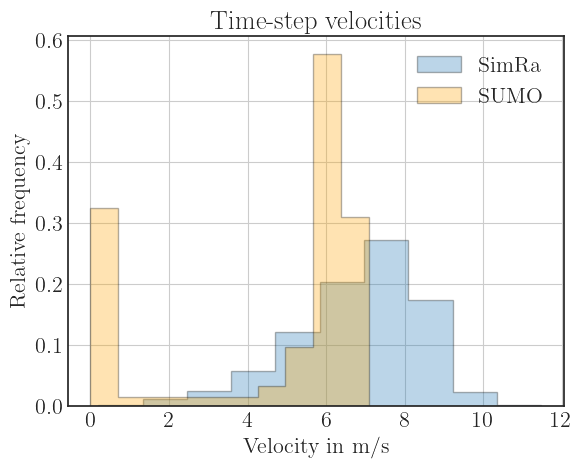

In [9]:
df_simra_paths.velo.hist(label='SimRa', **plt_kwargs)
df_sumo_paths.velo.hist(color='orange', label='SUMO', **plt_kwargs)
plt.legend()
plt.title('Time-step velocities')
plt.xlabel('Velocity in m/s')
plt.ylabel('Relative frequency')
plt.savefig('images/stillstand_analysis/simra_vs_sumo_velos.png', transparent=True)

In [10]:
def plot_ride_paths(ride_data: Dict[str, pd.DataFrame]):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect(1.5)
    
    colors = ['blue', 'orange', 'green', 'pink']

    # plot rides for each dataframe
    for data_idx, (data_name, df) in enumerate(ride_data.items()):
        df_grouped = df.groupby('ride_id')
        for ride_group_name in df_grouped.groups:
            df_ride_group = df_grouped.get_group(ride_group_name)
            ax.plot(df_ride_group.lon, df_ride_group.lat, color=colors[data_idx], label=data_name, linewidth=1)
            # add labels to legend 

    x_min = min(min(df.lon) for df in ride_data.values())
    x_max = max(max(df.lon) for df in ride_data.values())
    y_min = min(min(df.lat) for df in ride_data.values())
    y_max = max(max(df.lat) for df in ride_data.values())
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.xaxis.set_major_locator(ticker.LinearLocator(4))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_locator(ticker.LinearLocator(4))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.set_xlabel('Longitude in decimal degrees')
    ax.set_ylabel('Latitude in decimal degrees')

    # plt.savefig('simra_vs_sumo_ride_path.png', transparent=True)
    # plt.legend()
    plt.show()

In [11]:
ride_data = {'SimRa': df_simra_paths, 'SUMO': df_sumo_paths}

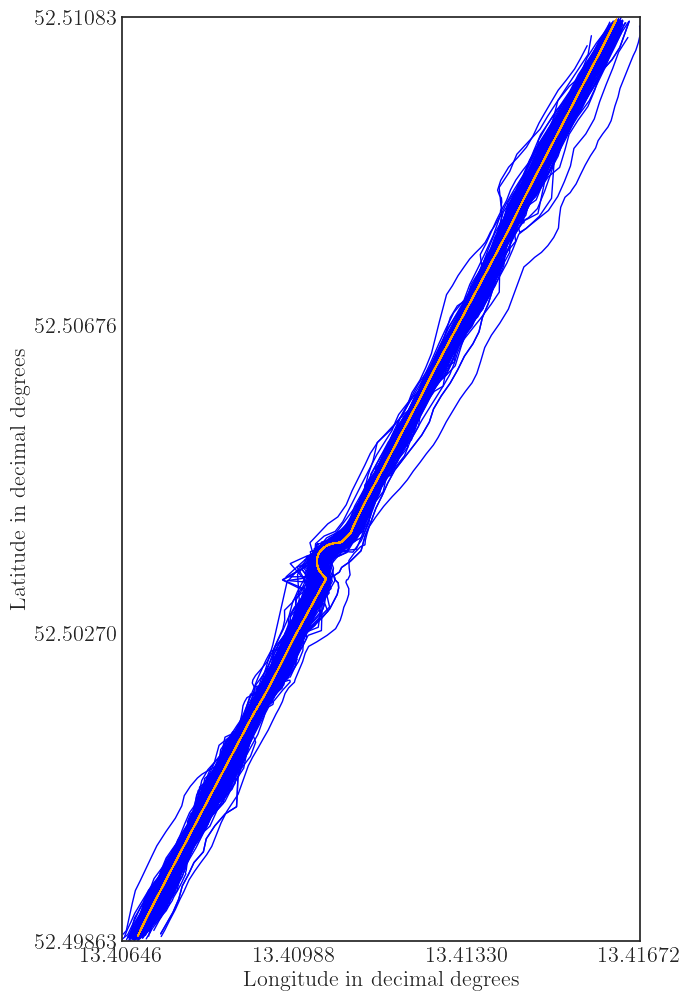

In [12]:
plot_ride_paths(ride_data)

In [13]:
velo_threshold = 1
length_threshold = 0

In [14]:
def plot_standstills(ride_data: Dict[str, pd.DataFrame], cluster_centers: List[np.array] = None, point_size: int = 1):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_aspect(1.7)

    colors = ['blue', 'orange', 'green', 'pink']

    # plot rides for each dataframe
    for data_idx, (data_name, df) in enumerate(ride_data.items()):
        df = df[df.velo < velo_threshold]
        ax.scatter(df.lon, df.lat, color=colors[data_idx], label=data_name, linewidth=point_size)

    if cluster_centers:
        cluster_centers_stacked = np.vstack(cluster_centers)
        ax.scatter(cluster_centers_stacked[:,0], cluster_centers_stacked[:,1], color='red', label='cluster center', linewidth=point_size)

    # ax.xaxis.set_major_locator(ticker.LinearLocator(8))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    # ax.yaxis.set_major_locator(ticker.LinearLocator(8))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.set_xlabel('Longitude in decimal degrees')
    ax.set_ylabel('Latitude in decimal degrees')

    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Stamen.Toner)
    # ax.set_xlim(rect_coords[0], rect_coords[2])
    # ax.set_ylim(rect_coords[1], rect_coords[3])

    ax.set_aspect(1.7)

    plt.legend()
    plt.savefig('images/stillstand_analysis/simra_vs_sumo_stillstand-locations.png', transparent=True, bbox_inches='tight')
    plt.show()

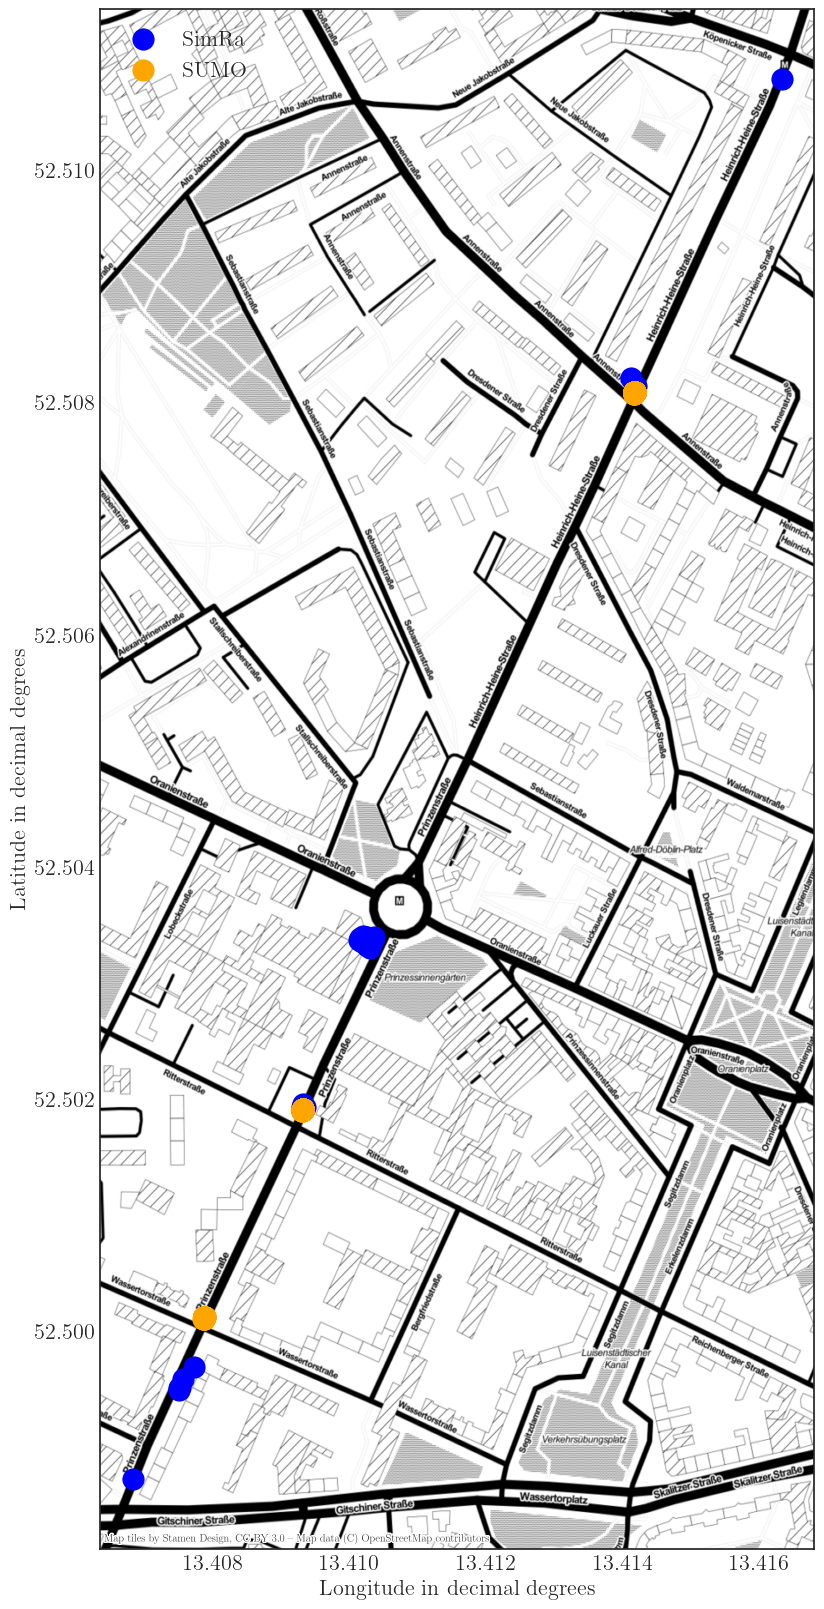

In [15]:
plot_standstills(ride_data, point_size=10)

In [16]:
def get_kmeans_cluster_centers(features: List[np.ndarray], n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, random_state=749)

    features_combined = np.hstack(features)
    cluster_labels = kmeans.fit_predict(features_combined)
    cluster_centers = kmeans.cluster_centers_

    return sorted(cluster_centers, key=lambda point: point[0])

In [17]:
def get_standstills(df: pd.DataFrame) -> List[int]:
    grouped = df.groupby('ride_id')

    standstills = []
    for _, ride_group in grouped:
        first_standstill_ts = None
        for row_idx, row in ride_group.iterrows():
            if row.velo < velo_threshold and not first_standstill_ts:
                first_standstill_ts = row.ts
            elif row.velo >= velo_threshold and first_standstill_ts:
                standstill_length = row.ts - first_standstill_ts
                if isinstance(standstill_length, pd.Timedelta):
                    standstill_length = standstill_length.total_seconds()
                
                if standstill_length > length_threshold:
                    standstills.append((standstill_length, (row.lon, row.lat)))
                
                first_standstill_ts = None

    return standstills

standstills = {}
standstill_cluster_centers = {}
for data_name, df in ride_data.items():
    standstills[data_name] = get_standstills(df)
    standstill_coords = list(list(zip(*standstills[data_name]))[1])
    standstill_lons = np.array(list(zip(*standstill_coords))[0]).reshape(-1, 1)
    standstill_lats = np.array(list(zip(*standstill_coords))[1]).reshape(-1, 1)
    standstill_cluster_centers[data_name] = get_kmeans_cluster_centers([standstill_lons, standstill_lats], n_clusters=3)

for data_name, standstills_ in standstills.items():
    print(f"Total number of standstills in {data_name}: {len(standstills_)}")

for data_name, standstill_cluster_centers_ in  standstill_cluster_centers.items():
    print(f"{data_name} standstill cluster centers:\n{standstill_cluster_centers_}")
    

/mnt/simra/data-analytics/.conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Total number of standstills in SimRa: 7
Total number of standstills in SUMO: 203
SimRa standstill cluster centers:
[array([13.4075623 , 52.49957293]), array([13.40980006, 52.50258154]), array([13.41484659, 52.50904543])]
SUMO standstill cluster centers:
[array([13.40784433, 52.50009629]), array([13.40928988, 52.50189093]), array([13.41414399, 52.50806682])]


/mnt/simra/data-analytics/.conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


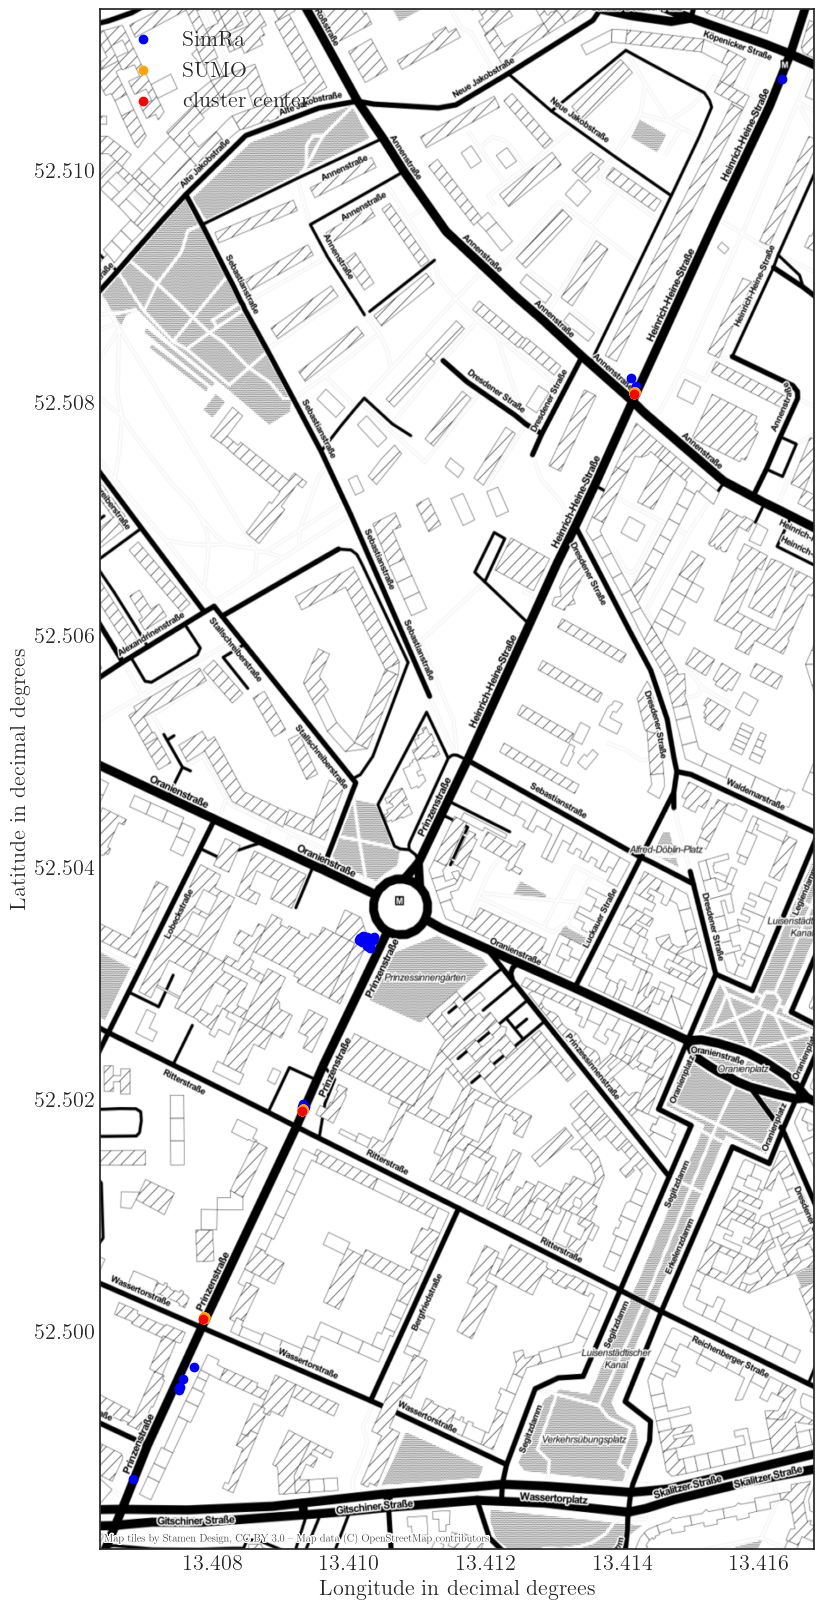

In [18]:
plot_standstills(ride_data, cluster_centers=standstill_cluster_centers['SUMO'])

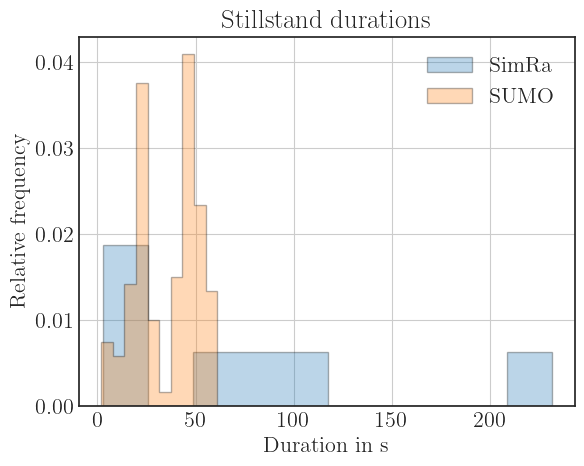

In [19]:
for data_name, standstills_ in standstills.items():    
        standstill_lengths = list(zip(*standstills_))[0]
        plt.hist(standstill_lengths, label=data_name, **plt_kwargs)

plt.grid(True)
plt.legend()
plt.title('Stillstand durations')
plt.xlabel('Duration in s')
plt.ylabel('Relative frequency')
plt.savefig('images/stillstand_analysis/simra_vs_sumo_stillstand-durations.png', transparent=True)

In [20]:
def point_to_box_coords(point_coords: Tuple[float], offset: float = 0.002):
    return (point_coords[0] - offset, point_coords[1] - offset * 1.5 , point_coords[0] + offset, point_coords[1] + offset * 1.5)

standstills_filtered_by_cluster = []
for cluster_idx, cluster_center in enumerate(standstill_cluster_centers['SUMO']):
    cluster_center_box = box(*point_to_box_coords(cluster_center))
    standstills_filtered_by_cluster.append({data_name: [s for s in standstills_ if cluster_center_box.contains(Point(*s[1]))] for data_name, standstills_ in standstills.items()})

In [21]:
def plot_filtered_standstills(ride_data: Dict[str, List[Tuple[float, Tuple[float, float]]]]):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect(1.5)
    
    colors = ['blue', 'orange', 'green', 'pink']

    for data_idx, (data_name, data) in enumerate(ride_data.items()):
        data_xy = list(list(zip(*data))[1])
        data_x = list(list(zip(*data_xy))[0])
        data_y = list(list(zip(*data_xy))[1])
        
        ax.scatter(data_x, data_y, color=colors[data_idx], label=data_name, linewidth=1)

    ax.xaxis.set_major_locator(ticker.LinearLocator(8))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_locator(ticker.LinearLocator(8))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.set_xlabel('Longitude in decimal degrees')
    ax.set_ylabel('Latitude in decimal degrees')

    plt.show()
    # plt.savefig('simra_vs_sumo_ride_path.png', transparent=True)
    # plt.legend()

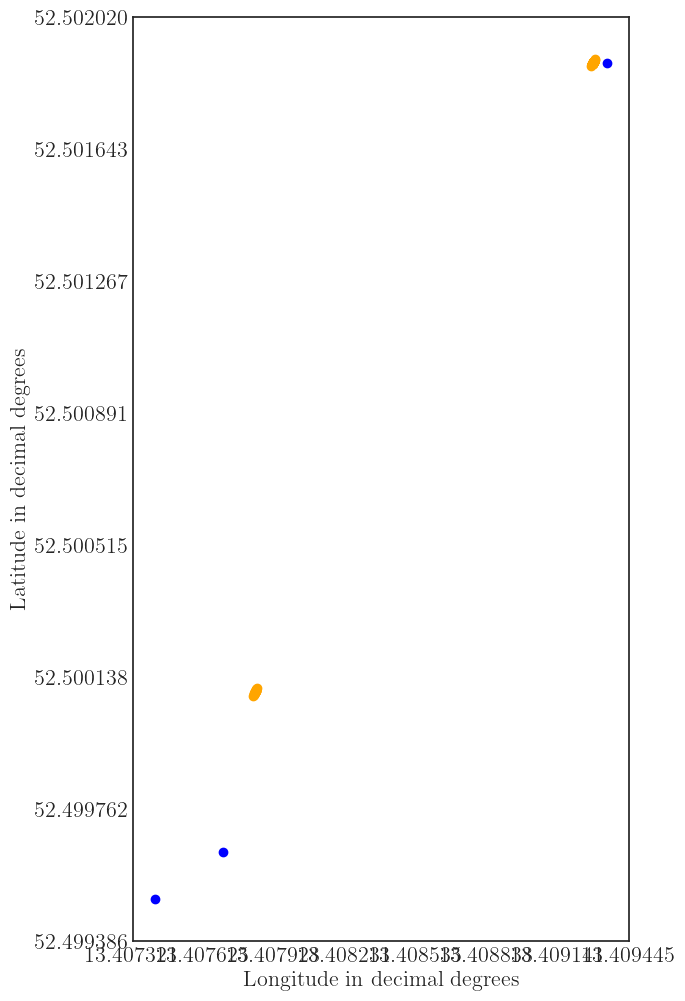

Number of stillstands in SimRa: 3 (Percentage of rides: 0.64)
Number of stillstands in SUMO: 118 (Percentage of rides: 120.41)


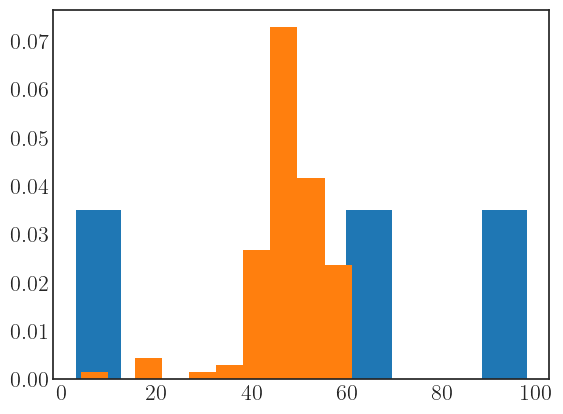

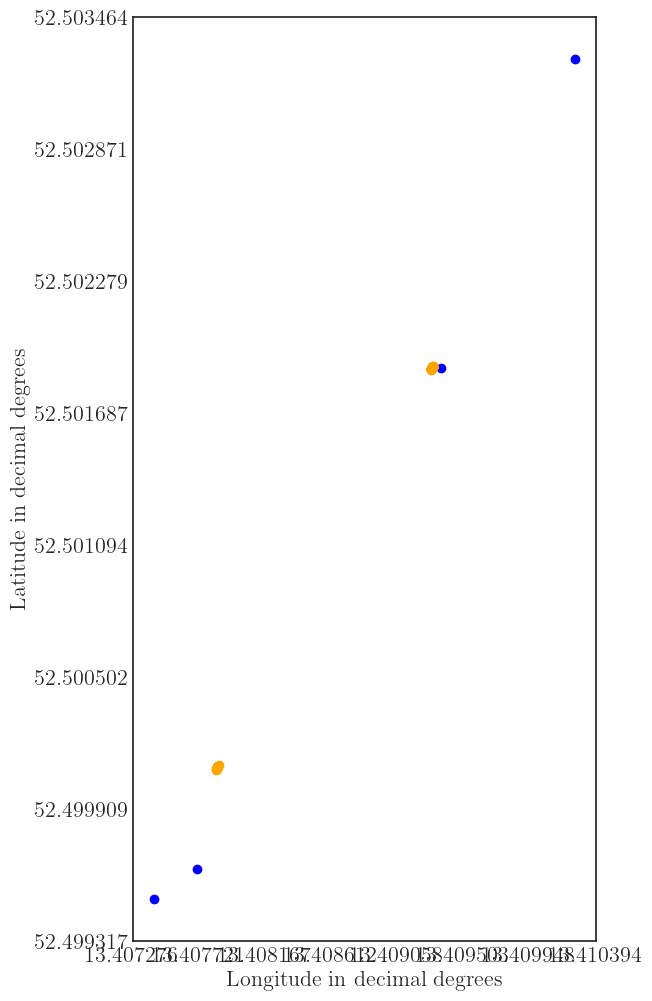

Number of stillstands in SimRa: 4 (Percentage of rides: 0.85)
Number of stillstands in SUMO: 118 (Percentage of rides: 120.41)


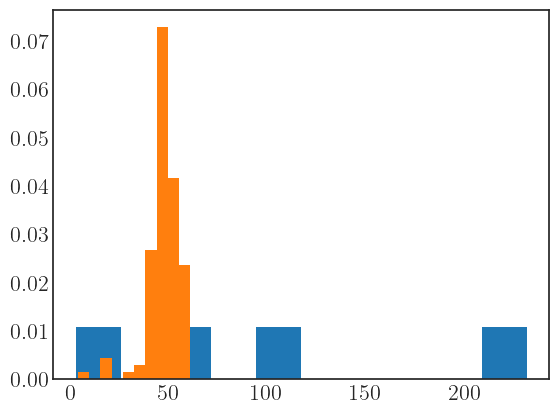

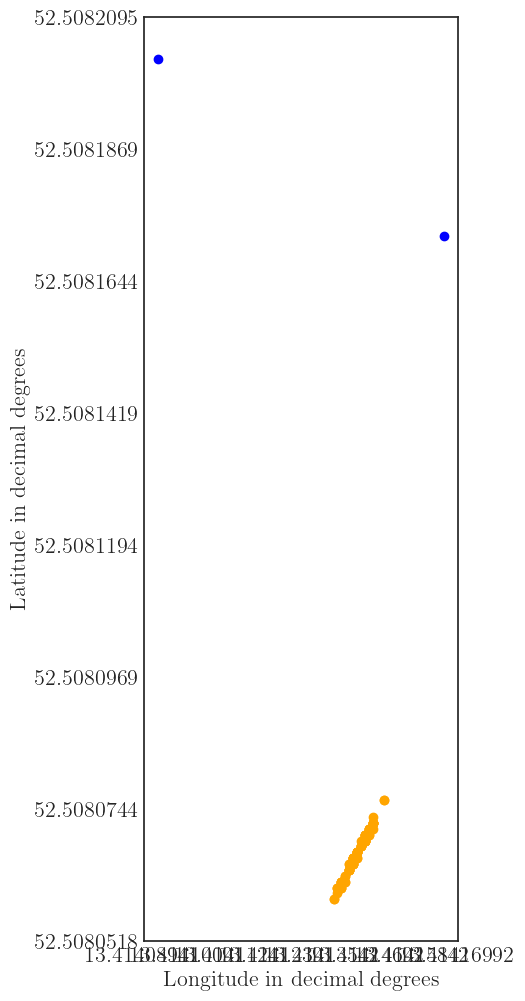

Number of stillstands in SimRa: 2 (Percentage of rides: 0.43)
Number of stillstands in SUMO: 85 (Percentage of rides: 86.73)


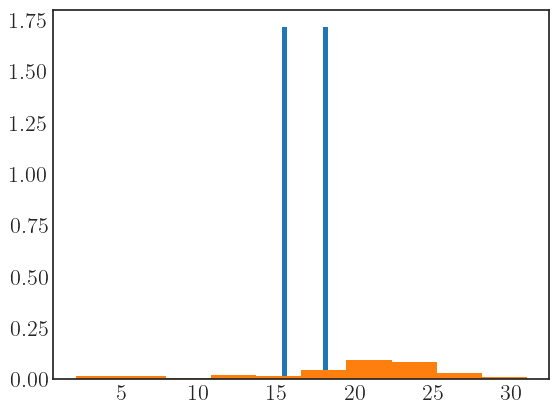

In [22]:
for cluster_standstills in standstills_filtered_by_cluster:
    plot_filtered_standstills(cluster_standstills)

    for data_name, cluster_standstills_ in cluster_standstills.items():    
        cluster_standstill_lengths = list(zip(*cluster_standstills_))[0]
        plt.hist(cluster_standstill_lengths, density=True)

        n_stillstands = len(cluster_standstill_lengths)
        print(f"Number of stillstands in {data_name}: {n_stillstands} (Percentage of rides: {n_stillstands / n_rides[data_name] * 100:.2f})")